In [34]:
# Compatibility layer between Python 2 and Python 3
from __future__ import print_function
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats

from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn import preprocessing

import tensorflow.keras as keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Reshape, GlobalAveragePooling1D
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Conv1D, MaxPooling1D
from tensorflow.keras.utils import np_utils



ImportError: cannot import name 'np_utils' from 'tensorflow.keras.utils' (/Users/narengs7/Anaconda/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/keras/api/_v2/keras/utils/__init__.py)

In [2]:
def feature_normalize(dataset):

    mu = np.mean(dataset, axis=0)
    sigma = np.std(dataset, axis=0)
    return (dataset - mu)/sigma


def show_confusion_matrix(validations, predictions):

    matrix = metrics.confusion_matrix(validations, predictions)
    plt.figure(figsize=(6, 4))
    sns.heatmap(matrix,
                cmap="coolwarm",
                linecolor='white',
                linewidths=1,
                xticklabels=LABELS,
                yticklabels=LABELS,
                annot=True,
                fmt="d")
    plt.title("Confusion Matrix")
    plt.ylabel("True Label")
    plt.xlabel("Predicted Label")
    plt.show()


def show_basic_dataframe_info(dataframe,
                              preview_rows=20):

    """
    This function shows basic information for the given dataframe
    Args:
        dataframe: A Pandas DataFrame expected to contain data
        preview_rows: An integer value of how many rows to preview
    Returns:
        Nothing
    """

    # Shape and how many rows and columns
    print("Number of columns in the dataframe: %i" % (dataframe.shape[1]))
    print("Number of rows in the dataframe: %i\n" % (dataframe.shape[0]))
    print("First 20 rows of the dataframe:\n")
    # Show first 20 rows
    print(dataframe.head(preview_rows))
    print("\nDescription of dataframe:\n")
    # Describe dataset like mean, min, max, etc.
    # print(dataframe.describe())


def read_data(file_path):

    """
    This function reads the accelerometer data from a file
    Args:
        file_path: URL pointing to the CSV file
    Returns:
        A pandas dataframe
    """

    column_names = ['user-id',
                    'activity',
                    'timestamp',
                    'x-axis',
                    'y-axis',
                    'z-axis']
    df = pd.read_csv(file_path,
                     header=None,
                     names=column_names)
    # Last column has a ";" character which must be removed ...
    df['z-axis'].replace(regex=True,
      inplace=True,
      to_replace=r';',
      value=r'')
    # ... and then this column must be transformed to float explicitly
    df['z-axis'] = df['z-axis'].apply(convert_to_float)
    # This is very important otherwise the model will not fit and loss
    # will show up as NAN
    df.dropna(axis=0, how='any', inplace=True)

    return df


def convert_to_float(x):

    try:
        return np.float(x)
    except:
        return np.nan


# Not used right now
def feature_normalize(dataset):

    mu = np.mean(dataset, axis=0)
    sigma = np.std(dataset, axis=0)
    return (dataset - mu)/sigma


def plot_axis(ax, x, y, title):

    ax.plot(x, y)
    ax.set_title(title)
    ax.xaxis.set_visible(False)
    ax.set_ylim([min(y) - np.std(y), max(y) + np.std(y)])
    ax.set_xlim([min(x), max(x)])
    ax.grid(True)


def plot_activity(activity, data):

    fig, (ax0, ax1, ax2) = plt.subplots(nrows=3,
         figsize=(15, 10),
         sharex=True)
    plot_axis(ax0, data['timestamp'], data['x-axis'], 'x-axis')
    plot_axis(ax1, data['timestamp'], data['y-axis'], 'y-axis')
    plot_axis(ax2, data['timestamp'], data['z-axis'], 'z-axis')
    plt.subplots_adjust(hspace=0.2)
    fig.suptitle(activity)
    plt.subplots_adjust(top=0.90)
    plt.show()


def create_segments_and_labels(df, time_steps, step, label_name):

    """
    This function receives a dataframe and returns the reshaped segments
    of x,y,z acceleration as well as the corresponding labels
    Args:
        df: Dataframe in the expected format
        time_steps: Integer value of the length of a segment that is created
    Returns:
        reshaped_segments
        labels:
    """

    # x, y, z acceleration as features
    N_FEATURES = 3
    # Number of steps to advance in each iteration (for me, it should always
    # be equal to the time_steps in order to have no overlap between segments)
    # step = time_steps
    segments = []
    labels = []
    for i in range(0, len(df) - time_steps, step):
        xs = df['x-axis'].values[i: i + time_steps]
        ys = df['y-axis'].values[i: i + time_steps]
        zs = df['z-axis'].values[i: i + time_steps]
        # Retrieve the most often used label in this segment
        label = stats.mode(df[label_name][i: i + time_steps])[0][0]
        segments.append([xs, ys, zs])
        labels.append(label)

    # Bring the segments into a better shape
    reshaped_segments = np.asarray(segments, dtype= np.float32).reshape(-1, time_steps, N_FEATURES)
    labels = np.asarray(labels)

    return reshaped_segments, labels



In [3]:
import pickle
def read_h5():
    lst = []
    with open("X and Y Dataset/x_train.pickle", "rb") as input_file:
        lst.append(pickle.load(input_file))
    with open("X and Y Dataset/y_train.pickle", "rb") as input_file:
        lst.append(pickle.load(input_file))
    with open("X and Y Dataset/x_test.pickle", "rb") as input_file:
        lst.append(pickle.load(input_file))
    with open("X and Y Dataset/y_test.pickle", "rb") as input_file:
        lst.append(pickle.load(input_file))
    return lst
def read_properties():
    lst = None
    with open('X and Y Dataset/properties.pickle','rb+') as fd:
        lst = pickle.load(fd)
    return lst
x_train,y_train,x_test,y_test = read_h5()
TIME_PERIODS = 80
num_time_periods, num_sensors,num_classes,input_shape = read_properties()
LABELS = ["Downstairs",
          "Jogging",
          "Sitting",
          "Standing",
          "Upstairs",
          "Walking"]

In [4]:
160*0.75

120.0


--- Create neural network model ---

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_3 (Reshape)          (None, 80, 3)             0         
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 76, 10)            160       
_________________________________________________________________
max_pooling1d_3 (MaxPooling1 (None, 25, 10)            0         
_________________________________________________________________
conv1d_6 (Conv1D)            (None, 16, 160)           16160     
_________________________________________________________________
dropout_3 (Dropout)          (None, 16, 160)           0         
_________________________________________________________________
global_average_pooling1d_3 ( (None, 160)               0         
_________________________________________________________________
dropout_4 (Dropo

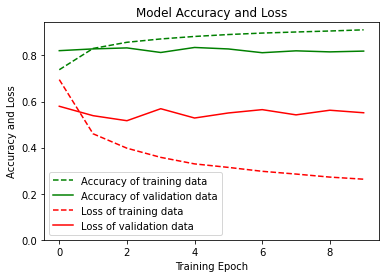


--- Check against test data ---

6584/6584 [==============================] - 0s 58us/step

Accuracy on test data: 0.88

Loss on test data: 0.38

--- Confusion matrix for test data ---



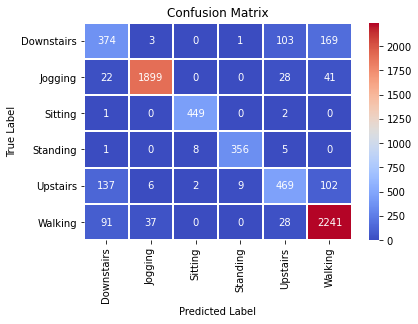


--- Classification report for test data ---

              precision    recall  f1-score   support

           0       0.60      0.58      0.59       650
           1       0.98      0.95      0.97      1990
           2       0.98      0.99      0.99       452
           3       0.97      0.96      0.97       370
           4       0.74      0.65      0.69       725
           5       0.88      0.93      0.91      2397

    accuracy                           0.88      6584
   macro avg       0.86      0.84      0.85      6584
weighted avg       0.88      0.88      0.88      6584



In [7]:
print("\n--- Create neural network model ---\n")

# 1D CNN neural network
model_m = Sequential()
model_m.add(Reshape((TIME_PERIODS, num_sensors), input_shape=(input_shape,)))
model_m.add(Conv1D(10, 5, activation='relu', input_shape=(TIME_PERIODS, num_sensors)))
model_m.add(MaxPooling1D(3))
model_m.add(Conv1D(160, 10, activation='relu'))
model_m.add(Dropout(0.5))
model_m.add(GlobalAveragePooling1D())
model_m.add(Dropout(0.5))
model_m.add(Dense(num_classes, activation='softmax'))
print(model_m.summary())
# Accuracy on training data: 99%
# Accuracy on test data: 91%

print("\n--- Fit the model ---\n")

# The EarlyStopping callback monitors training accuracy:
# if it fails to improve for two consecutive epochs,
# training stops early
callbacks_list = [
    keras.callbacks.EarlyStopping(monitor='accuracy', patience=1)
]

model_m.compile(loss='categorical_crossentropy',
                optimizer='adam', metrics=['accuracy'])

BATCH_SIZE = 25
EPOCHS = 10

# Enable validation to use ModelCheckpoint and EarlyStopping callbacks.
history = model_m.fit(x_train,
                      y_train,
                      batch_size=BATCH_SIZE,
                      epochs=EPOCHS,
                      callbacks=callbacks_list,
                      validation_split=0.2,
                      verbose=1)

print("\n--- Learning curve of model training ---\n")

# summarize history for accuracy and loss
plt.figure(figsize=(6, 4))
plt.plot(history.history['accuracy'], "g--", label="Accuracy of training data")
plt.plot(history.history['val_accuracy'], "g", label="Accuracy of validation data")
plt.plot(history.history['loss'], "r--", label="Loss of training data")
plt.plot(history.history['val_loss'], "r", label="Loss of validation data")
plt.title('Model Accuracy and Loss')
plt.ylabel('Accuracy and Loss')
plt.xlabel('Training Epoch')
plt.ylim(0)
plt.legend()
plt.show()
print("\n--- Check against test data ---\n")

score = model_m.evaluate(x_test, y_test, verbose=1)

print("\nAccuracy on test data: %0.2f" % score[1])
print("\nLoss on test data: %0.2f" % score[0])

print("\n--- Confusion matrix for test data ---\n")

y_pred_test = model_m.predict(x_test)
# Take the class with the highest probability from the test predictions
max_y_pred_test = np.argmax(y_pred_test, axis=1)
max_y_test = np.argmax(y_test, axis=1)

show_confusion_matrix(max_y_test, max_y_pred_test)
print("\n--- Classification report for test data ---\n")

print(classification_report(max_y_test, max_y_pred_test))


--- Create neural network model ---

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_8 (Reshape)          (None, 80, 3)             0         
_________________________________________________________________
conv1d_15 (Conv1D)           (None, 71, 100)           3100      
_________________________________________________________________
max_pooling1d_8 (MaxPooling1 (None, 23, 100)           0         
_________________________________________________________________
conv1d_16 (Conv1D)           (None, 14, 160)           160160    
_________________________________________________________________
global_average_pooling1d_8 ( (None, 160)               0         
_________________________________________________________________
dropout_10 (Dropout)         (None, 160)               0         
_________________________________________________________________
dense_10 (Dense)

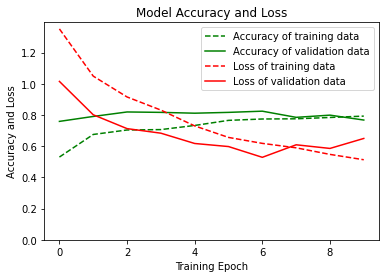


--- Check against test data ---

6584/6584 [==============================] - 1s 84us/step

Accuracy on test data: 0.85

Loss on test data: 0.40

--- Confusion matrix for test data ---



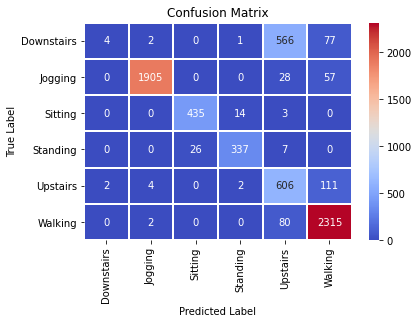


--- Classification report for test data ---

              precision    recall  f1-score   support

           0       0.67      0.01      0.01       650
           1       1.00      0.96      0.98      1990
           2       0.94      0.96      0.95       452
           3       0.95      0.91      0.93       370
           4       0.47      0.84      0.60       725
           5       0.90      0.97      0.93      2397

    accuracy                           0.85      6584
   macro avg       0.82      0.77      0.73      6584
weighted avg       0.87      0.85      0.82      6584



In [12]:
print("\n--- Create neural network model ---\n")

# 1D CNN neural network
model_m = Sequential()
model_m.add(Reshape((TIME_PERIODS, num_sensors), input_shape=(input_shape,)))
model_m.add(Conv1D(100, 10, activation='relu', input_shape=(TIME_PERIODS, num_sensors)))
model_m.add(MaxPooling1D(3))
model_m.add(Conv1D(160, 10, activation='relu'))
model_m.add(GlobalAveragePooling1D())
model_m.add(Dropout(0.5))
model_m.add(Dense(50, activation='softmax'))
model_m.add(Dropout(0.5))
model_m.add(Dense(num_classes, activation='softmax'))
print(model_m.summary())
# Accuracy on training data: 99%
# Accuracy on test data: 91%

print("\n--- Fit the model ---\n")

# The EarlyStopping callback monitors training accuracy:
# if it fails to improve for two consecutive epochs,
# training stops early
callbacks_list = [
    keras.callbacks.EarlyStopping(monitor='accuracy', patience=1)
]

model_m.compile(loss='categorical_crossentropy',
                optimizer='adam', metrics=['accuracy'])

BATCH_SIZE = 25
EPOCHS = 10

# Enable validation to use ModelCheckpoint and EarlyStopping callbacks.
history = model_m.fit(x_train,
                      y_train,
                      batch_size=BATCH_SIZE,
                      epochs=EPOCHS,
                      callbacks=callbacks_list,
                      validation_split=0.2,
                      verbose=1)

print("\n--- Learning curve of model training ---\n")

# summarize history for accuracy and loss
plt.figure(figsize=(6, 4))
plt.plot(history.history['accuracy'], "g--", label="Accuracy of training data")
plt.plot(history.history['val_accuracy'], "g", label="Accuracy of validation data")
plt.plot(history.history['loss'], "r--", label="Loss of training data")
plt.plot(history.history['val_loss'], "r", label="Loss of validation data")
plt.title('Model Accuracy and Loss')
plt.ylabel('Accuracy and Loss')
plt.xlabel('Training Epoch')
plt.ylim(0)
plt.legend()
plt.show()
print("\n--- Check against test data ---\n")

score = model_m.evaluate(x_test, y_test, verbose=1)

print("\nAccuracy on test data: %0.2f" % score[1])
print("\nLoss on test data: %0.2f" % score[0])

print("\n--- Confusion matrix for test data ---\n")

y_pred_test = model_m.predict(x_test)
# Take the class with the highest probability from the test predictions
max_y_pred_test = np.argmax(y_pred_test, axis=1)
max_y_test = np.argmax(y_test, axis=1)

show_confusion_matrix(max_y_test, max_y_pred_test)
print("\n--- Classification report for test data ---\n")

print(classification_report(max_y_test, max_y_pred_test))


--- Create neural network model ---

Model: "sequential_21"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_21 (Reshape)         (None, 80, 3)             0         
_________________________________________________________________
conv1d_41 (Conv1D)           (None, 71, 100)           3100      
_________________________________________________________________
max_pooling1d_21 (MaxPooling (None, 23, 100)           0         
_________________________________________________________________
conv1d_42 (Conv1D)           (None, 14, 160)           160160    
_________________________________________________________________
global_average_pooling1d_21  (None, 160)               0         
_________________________________________________________________
dropout_36 (Dropout)         (None, 160)               0         
_________________________________________________________________
dense_33 (Dense

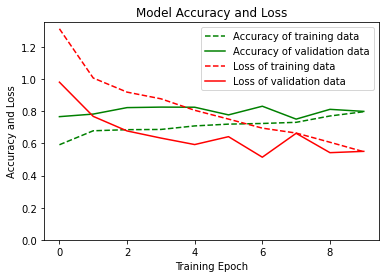


--- Check against test data ---

6584/6584 [==============================] - 1s 129us/step

Accuracy on test data: 0.84

Loss on test data: 0.42

--- Confusion matrix for test data ---



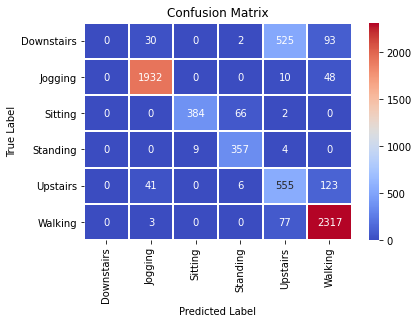


--- Classification report for test data ---

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       650
           1       0.96      0.97      0.97      1990
           2       0.98      0.85      0.91       452
           3       0.83      0.96      0.89       370
           4       0.47      0.77      0.58       725
           5       0.90      0.97      0.93      2397

    accuracy                           0.84      6584
   macro avg       0.69      0.75      0.71      6584
weighted avg       0.78      0.84      0.81      6584



/Users/narengs7/Anaconda/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [25]:
print("\n--- Create neural network model ---\n")

# 1D CNN neural network
model_m = Sequential()
model_m.add(Reshape((TIME_PERIODS, num_sensors), input_shape=(input_shape,)))
model_m.add(Conv1D(100, 10, activation='relu', input_shape=(TIME_PERIODS, num_sensors)))
model_m.add(MaxPooling1D(3))
model_m.add(Conv1D(160, 10, activation='relu'))
model_m.add(GlobalAveragePooling1D())
model_m.add(Dropout(0.5))
model_m.add(Dense(50, activation='softmax'))
model_m.add(Dropout(0.5))
model_m.add(Dense(num_classes, activation='softmax'))
print(model_m.summary())
# Accuracy on training data: 99%
# Accuracy on test data: 91%

print("\n--- Fit the model ---\n")

# The EarlyStopping callback monitors training accuracy:
# if it fails to improve for two consecutive epochs,
# training stops early
callbacks_list = [
    keras.callbacks.EarlyStopping(monitor='accuracy', patience=1)
]

model_m.compile(loss='categorical_crossentropy',
                optimizer='adam', metrics=['accuracy'])

BATCH_SIZE = 25
EPOCHS = 10

# Enable validation to use ModelCheckpoint and EarlyStopping callbacks.
history = model_m.fit(x_train,
                      y_train,
                      batch_size=BATCH_SIZE,
                      epochs=EPOCHS,
                      callbacks=callbacks_list,
                      validation_split=0.2,
                      verbose=1)

print("\n--- Learning curve of model training ---\n")

# summarize history for accuracy and loss
plt.figure(figsize=(6, 4))
plt.plot(history.history['accuracy'], "g--", label="Accuracy of training data")
plt.plot(history.history['val_accuracy'], "g", label="Accuracy of validation data")
plt.plot(history.history['loss'], "r--", label="Loss of training data")
plt.plot(history.history['val_loss'], "r", label="Loss of validation data")
plt.title('Model Accuracy and Loss')
plt.ylabel('Accuracy and Loss')
plt.xlabel('Training Epoch')
plt.ylim(0)
plt.legend()
plt.show()
print("\n--- Check against test data ---\n")

score = model_m.evaluate(x_test, y_test, verbose=1)

print("\nAccuracy on test data: %0.2f" % score[1])
print("\nLoss on test data: %0.2f" % score[0])

print("\n--- Confusion matrix for test data ---\n")

y_pred_test = model_m.predict(x_test)
# Take the class with the highest probability from the test predictions
max_y_pred_test = np.argmax(y_pred_test, axis=1)
max_y_test = np.argmax(y_test, axis=1)

show_confusion_matrix(max_y_test, max_y_pred_test)
print("\n--- Classification report for test data ---\n")

print(classification_report(max_y_test, max_y_pred_test))


--- Create neural network model ---

Model: "sequential_24"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_24 (Reshape)         (None, 80, 3)             0         
_________________________________________________________________
conv1d_51 (Conv1D)           (None, 71, 100)           3100      
_________________________________________________________________
conv1d_52 (Conv1D)           (None, 62, 100)           100100    
_________________________________________________________________
max_pooling1d_24 (MaxPooling (None, 20, 100)           0         
_________________________________________________________________
dropout_41 (Dropout)         (None, 20, 100)           0         
_________________________________________________________________
conv1d_53 (Conv1D)           (None, 11, 160)           160160    
_________________________________________________________________
conv1d_54 (Conv

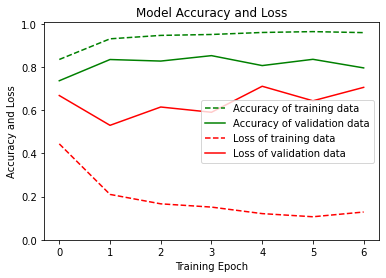


--- Check against test data ---

6584/6584 [==============================] - 2s 235us/step

Accuracy on test data: 0.92

Loss on test data: 0.38

--- Confusion matrix for test data ---



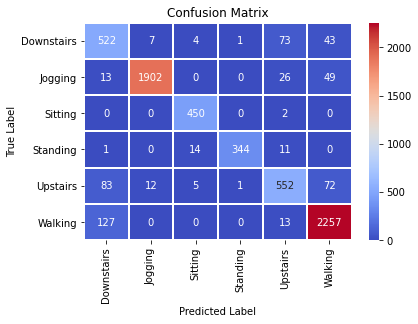


--- Classification report for test data ---

              precision    recall  f1-score   support

           0       0.70      0.80      0.75       650
           1       0.99      0.96      0.97      1990
           2       0.95      1.00      0.97       452
           3       0.99      0.93      0.96       370
           4       0.82      0.76      0.79       725
           5       0.93      0.94      0.94      2397

    accuracy                           0.92      6584
   macro avg       0.90      0.90      0.90      6584
weighted avg       0.92      0.92      0.92      6584



In [28]:
print("\n--- Create neural network model ---\n")

# 1D CNN neural network
model_m = Sequential()
model_m.add(Reshape((TIME_PERIODS, num_sensors), input_shape=(input_shape,)))
model_m.add(Conv1D(100, 10, activation='relu', input_shape=(TIME_PERIODS, num_sensors)))
model_m.add(Conv1D(100, 10, activation='relu'))
model_m.add(MaxPooling1D(3))
model_m.add(Dropout(0.5))
model_m.add(Conv1D(160, 10, activation='relu'))
model_m.add(Conv1D(160, 10, activation='relu'))
model_m.add(GlobalAveragePooling1D())
model_m.add(Dropout(0.5))
model_m.add(Dense(num_classes, activation='softmax'))
print(model_m.summary())
# Accuracy on training data: 99%
# Accuracy on test data: 91%

print("\n--- Fit the model ---\n")

# The EarlyStopping callback monitors training accuracy:
# if it fails to improve for two consecutive epochs,
# training stops early
callbacks_list = [
    keras.callbacks.EarlyStopping(monitor='accuracy', patience=1)
]

model_m.compile(loss='categorical_crossentropy',
                optimizer='adam', metrics=['accuracy'])

BATCH_SIZE = 25
EPOCHS = 10

# Enable validation to use ModelCheckpoint and EarlyStopping callbacks.
history = model_m.fit(x_train,
                      y_train,
                      batch_size=BATCH_SIZE,
                      epochs=EPOCHS,
                      callbacks=callbacks_list,
                      validation_split=0.2,
                      verbose=1)

print("\n--- Learning curve of model training ---\n")

# summarize history for accuracy and loss
plt.figure(figsize=(6, 4))
plt.plot(history.history['accuracy'], "g--", label="Accuracy of training data")
plt.plot(history.history['val_accuracy'], "g", label="Accuracy of validation data")
plt.plot(history.history['loss'], "r--", label="Loss of training data")
plt.plot(history.history['val_loss'], "r", label="Loss of validation data")
plt.title('Model Accuracy and Loss')
plt.ylabel('Accuracy and Loss')
plt.xlabel('Training Epoch')
plt.ylim(0)
plt.legend()
plt.show()
print("\n--- Check against test data ---\n")

score = model_m.evaluate(x_test, y_test, verbose=1)

print("\nAccuracy on test data: %0.2f" % score[1])
print("\nLoss on test data: %0.2f" % score[0])

print("\n--- Confusion matrix for test data ---\n")

y_pred_test = model_m.predict(x_test)
# Take the class with the highest probability from the test predictions
max_y_pred_test = np.argmax(y_pred_test, axis=1)
max_y_test = np.argmax(y_test, axis=1)

show_confusion_matrix(max_y_test, max_y_pred_test)
print("\n--- Classification report for test data ---\n")

print(classification_report(max_y_test, max_y_pred_test))

# ToDO

### Two ways to regularization
1. tweek NN - like dropout, kernal_regularization in dropout
2. Batch normalization



WHen use l2 when needed to identified,based on tiny details


--- Create neural network model ---

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_1 (Reshape)          (None, 80, 3)             0         
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 71, 100)           3100      
_________________________________________________________________
batch_normalization_3 (Batch (None, 71, 100)           400       
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 62, 100)           100100    
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 20, 100)           0         
_________________________________________________________________
conv1d_6 (Conv1D)            (None, 11, 160)           160160    
_________________________________________________________________
conv1d_7 (Conv1D

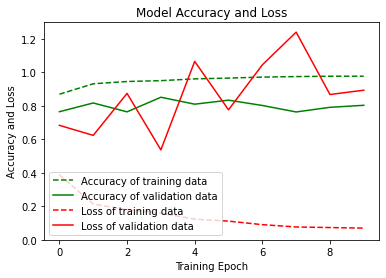


--- Check against test data ---

6584/6584 [==============================] - 1s 192us/sample - loss: 1.1761 - accuracy: 0.8648

Accuracy on test data: 0.86

Loss on test data: 1.18

--- Confusion matrix for test data ---



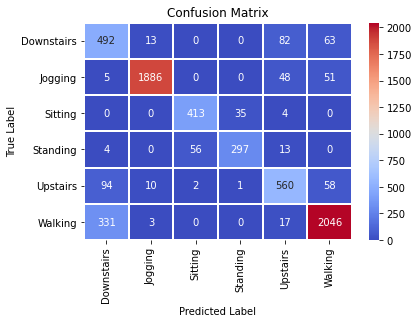


--- Classification report for test data ---

              precision    recall  f1-score   support

           0       0.53      0.76      0.62       650
           1       0.99      0.95      0.97      1990
           2       0.88      0.91      0.89       452
           3       0.89      0.80      0.84       370
           4       0.77      0.77      0.77       725
           5       0.92      0.85      0.89      2397

    accuracy                           0.86      6584
   macro avg       0.83      0.84      0.83      6584
weighted avg       0.88      0.86      0.87      6584



In [36]:
from tensorflow.keras import regularizers
from tensorflow.keras.layers import BatchNormalization
print("\n--- Create neural network model ---\n")

# 1D CNN neural network
model_m = Sequential()
model_m.add(Reshape((TIME_PERIODS, num_sensors), input_shape=(input_shape,)))
model_m.add(Conv1D(100, 10, activation='relu', input_shape=(TIME_PERIODS, num_sensors)))
model_m.add(BatchNormalization())
model_m.add(Conv1D(100, 10, activation='relu'))
model_m.add(MaxPooling1D(3))
model_m.add(Conv1D(160, 10, activation='relu'))
model_m.add(Conv1D(160, 10, activation='relu'))
model_m.add(GlobalAveragePooling1D())
model_m.add(Dropout(0.5))
model_m.add(Dense(num_classes, activation='softmax'))
print(model_m.summary())
# Accuracy on training data: 99%
# Accuracy on test data: 91%

print("\n--- Fit the model ---\n")

# The EarlyStopping callback monitors training accuracy:
# if it fails to improve for two consecutive epochs,
# training stops early
callbacks_list = [
    keras.callbacks.EarlyStopping(monitor='accuracy', patience=1)
]

model_m.compile(loss='categorical_crossentropy',
                optimizer='adam', metrics=['accuracy'])

BATCH_SIZE = 25
EPOCHS = 10

# Enable validation to use ModelCheckpoint and EarlyStopping callbacks.
history = model_m.fit(x_train,
                      y_train,
                      batch_size=BATCH_SIZE,
                      epochs=EPOCHS,
                      callbacks=callbacks_list,
                      validation_split=0.2,
                      verbose=1)

print("\n--- Learning curve of model training ---\n")

# summarize history for accuracy and loss
plt.figure(figsize=(6, 4))
plt.plot(history.history['accuracy'], "g--", label="Accuracy of training data")
plt.plot(history.history['val_accuracy'], "g", label="Accuracy of validation data")
plt.plot(history.history['loss'], "r--", label="Loss of training data")
plt.plot(history.history['val_loss'], "r", label="Loss of validation data")
plt.title('Model Accuracy and Loss')
plt.ylabel('Accuracy and Loss')
plt.xlabel('Training Epoch')
plt.ylim(0)
plt.legend()
plt.show()
print("\n--- Check against test data ---\n")

score = model_m.evaluate(x_test, y_test, verbose=1)

print("\nAccuracy on test data: %0.2f" % score[1])
print("\nLoss on test data: %0.2f" % score[0])

print("\n--- Confusion matrix for test data ---\n")

y_pred_test = model_m.predict(x_test)
# Take the class with the highest probability from the test predictions
max_y_pred_test = np.argmax(y_pred_test, axis=1)
max_y_test = np.argmax(y_test, axis=1)

show_confusion_matrix(max_y_test, max_y_pred_test)
print("\n--- Classification report for test data ---\n")

print(classification_report(max_y_test, max_y_pred_test))


--- Create neural network model ---

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_2 (Reshape)          (None, 80, 3)             0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 76, 10)            160       
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 25, 10)            0         
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 16, 100)           10100     
_________________________________________________________________
global_average_pooling1d_2 ( (None, 100)               0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_2 (Dense) 

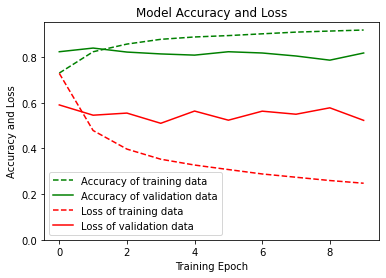


--- Check against test data ---

6584/6584 [==============================] - 0s 32us/step

Accuracy on test data: 0.89

Loss on test data: 0.36

--- Confusion matrix for test data ---



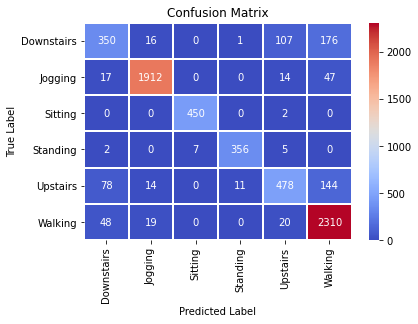


--- Classification report for test data ---

              precision    recall  f1-score   support

           0       0.71      0.54      0.61       650
           1       0.98      0.96      0.97      1990
           2       0.98      1.00      0.99       452
           3       0.97      0.96      0.96       370
           4       0.76      0.66      0.71       725
           5       0.86      0.96      0.91      2397

    accuracy                           0.89      6584
   macro avg       0.88      0.85      0.86      6584
weighted avg       0.88      0.89      0.88      6584



In [6]:
print("\n--- Create neural network model ---\n")

# 1D CNN neural network
model_m = Sequential()
model_m.add(Reshape((TIME_PERIODS, num_sensors), input_shape=(input_shape,)))
model_m.add(Conv1D(10, 5, activation='relu', input_shape=(TIME_PERIODS, num_sensors)))
model_m.add(MaxPooling1D(3))
model_m.add(Conv1D(100, 10, activation='relu'))
model_m.add(GlobalAveragePooling1D())
model_m.add(Dropout(0.5))
model_m.add(Dense(num_classes, activation='softmax'))
print(model_m.summary())
# Accuracy on training data: 99%
# Accuracy on test data: 91%

print("\n--- Fit the model ---\n")

# The EarlyStopping callback monitors training accuracy:
# if it fails to improve for two consecutive epochs,
# training stops early
callbacks_list = [
    keras.callbacks.EarlyStopping(monitor='accuracy', patience=1)
]

model_m.compile(loss='categorical_crossentropy',
                optimizer='adam', metrics=['accuracy'])

BATCH_SIZE = 25
EPOCHS = 10

# Enable validation to use ModelCheckpoint and EarlyStopping callbacks.
history = model_m.fit(x_train,
                      y_train,
                      batch_size=BATCH_SIZE,
                      epochs=EPOCHS,
                      callbacks=callbacks_list,
                      validation_split=0.2,
                      verbose=1)

print("\n--- Learning curve of model training ---\n")

# summarize history for accuracy and loss
plt.figure(figsize=(6, 4))
plt.plot(history.history['accuracy'], "g--", label="Accuracy of training data")
plt.plot(history.history['val_accuracy'], "g", label="Accuracy of validation data")
plt.plot(history.history['loss'], "r--", label="Loss of training data")
plt.plot(history.history['val_loss'], "r", label="Loss of validation data")
plt.title('Model Accuracy and Loss')
plt.ylabel('Accuracy and Loss')
plt.xlabel('Training Epoch')
plt.ylim(0)
plt.legend()
plt.show()
print("\n--- Check against test data ---\n")

score = model_m.evaluate(x_test, y_test, verbose=1)

print("\nAccuracy on test data: %0.2f" % score[1])
print("\nLoss on test data: %0.2f" % score[0])

print("\n--- Confusion matrix for test data ---\n")

y_pred_test = model_m.predict(x_test)
# Take the class with the highest probability from the test predictions
max_y_pred_test = np.argmax(y_pred_test, axis=1)
max_y_test = np.argmax(y_test, axis=1)

show_confusion_matrix(max_y_test, max_y_pred_test)
print("\n--- Classification report for test data ---\n")

print(classification_report(max_y_test, max_y_pred_test))


--- Create neural network model ---

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_7 (Reshape)          (None, 80, 3)             0         
_________________________________________________________________
conv1d_14 (Conv1D)           (None, 76, 10)            160       
_________________________________________________________________
max_pooling1d_7 (MaxPooling1 (None, 25, 10)            0         
_________________________________________________________________
conv1d_15 (Conv1D)           (None, 16, 100)           10100     
_________________________________________________________________
conv1d_16 (Conv1D)           (None, 7, 100)            100100    
_________________________________________________________________
global_average_pooling1d_7 ( (None, 100)               0         
_________________________________________________________________
dropout_7 (Dropo

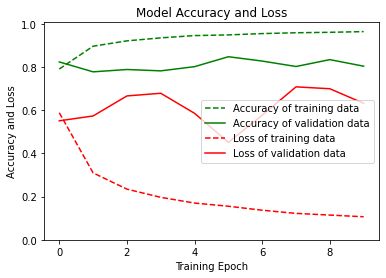


--- Check against test data ---

6584/6584 [==============================] - 0s 46us/step

Accuracy on test data: 0.85

Loss on test data: 0.58

--- Confusion matrix for test data ---



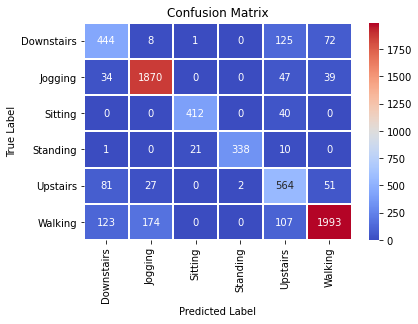


--- Classification report for test data ---

              precision    recall  f1-score   support

           0       0.65      0.68      0.67       650
           1       0.90      0.94      0.92      1990
           2       0.95      0.91      0.93       452
           3       0.99      0.91      0.95       370
           4       0.63      0.78      0.70       725
           5       0.92      0.83      0.88      2397

    accuracy                           0.85      6584
   macro avg       0.84      0.84      0.84      6584
weighted avg       0.86      0.85      0.86      6584



In [14]:
print("\n--- Create neural network model ---\n")

# 1D CNN neural network
model_m = Sequential()
model_m.add(Reshape((TIME_PERIODS, num_sensors), input_shape=(input_shape,)))
model_m.add(Conv1D(10, 5, activation='relu', input_shape=(TIME_PERIODS, num_sensors)))
model_m.add(MaxPooling1D(3))
model_m.add(Conv1D(100, 10, activation='relu'))
model_m.add(Conv1D(100, 10, activation='relu'))
model_m.add(GlobalAveragePooling1D())
model_m.add(Dropout(0.5))
model_m.add(Dense(num_classes, activation='softmax'))
print(model_m.summary())
# Accuracy on training data: 99%
# Accuracy on test data: 91%

print("\n--- Fit the model ---\n")

# The EarlyStopping callback monitors training accuracy:
# if it fails to improve for two consecutive epochs,
# training stops early
callbacks_list = [
    keras.callbacks.EarlyStopping(monitor='accuracy', patience=1)
]

model_m.compile(loss='categorical_crossentropy',
                optimizer='adam', metrics=['accuracy'])

BATCH_SIZE = 25
EPOCHS = 10

# Enable validation to use ModelCheckpoint and EarlyStopping callbacks.
history = model_m.fit(x_train,
                      y_train,
                      batch_size=BATCH_SIZE,
                      epochs=EPOCHS,
                      callbacks=callbacks_list,
                      validation_split=0.2,
                      verbose=1)

print("\n--- Learning curve of model training ---\n")

# summarize history for accuracy and loss
plt.figure(figsize=(6, 4))
plt.plot(history.history['accuracy'], "g--", label="Accuracy of training data")
plt.plot(history.history['val_accuracy'], "g", label="Accuracy of validation data")
plt.plot(history.history['loss'], "r--", label="Loss of training data")
plt.plot(history.history['val_loss'], "r", label="Loss of validation data")
plt.title('Model Accuracy and Loss')
plt.ylabel('Accuracy and Loss')
plt.xlabel('Training Epoch')
plt.ylim(0)
plt.legend()
plt.show()
print("\n--- Check against test data ---\n")

score = model_m.evaluate(x_test, y_test, verbose=1)

print("\nAccuracy on test data: %0.2f" % score[1])
print("\nLoss on test data: %0.2f" % score[0])

print("\n--- Confusion matrix for test data ---\n")

y_pred_test = model_m.predict(x_test)
# Take the class with the highest probability from the test predictions
max_y_pred_test = np.argmax(y_pred_test, axis=1)
max_y_test = np.argmax(y_test, axis=1)

show_confusion_matrix(max_y_test, max_y_pred_test)
print("\n--- Classification report for test data ---\n")

print(classification_report(max_y_test, max_y_pred_test))


--- Create neural network model ---

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_8 (Reshape)          (None, 80, 3)             0         
_________________________________________________________________
conv1d_17 (Conv1D)           (None, 76, 10)            160       
_________________________________________________________________
max_pooling1d_8 (MaxPooling1 (None, 25, 10)            0         
_________________________________________________________________
conv1d_18 (Conv1D)           (None, 16, 10)            1010      
_________________________________________________________________
global_average_pooling1d_8 ( (None, 10)                0         
_________________________________________________________________
dropout_8 (Dropout)          (None, 10)                0         
_________________________________________________________________
dense_8 (Dense) 

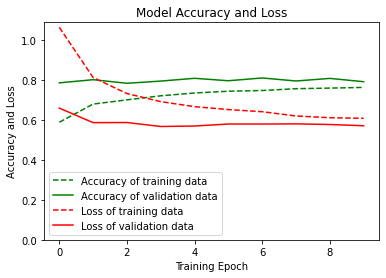


--- Check against test data ---

6584/6584 [==============================] - 0s 33us/step

Accuracy on test data: 0.81

Loss on test data: 0.52

--- Confusion matrix for test data ---



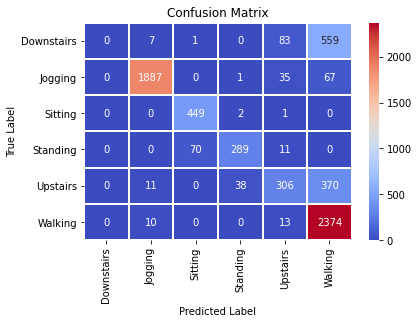


--- Classification report for test data ---

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       650
           1       0.99      0.95      0.97      1990
           2       0.86      0.99      0.92       452
           3       0.88      0.78      0.83       370
           4       0.68      0.42      0.52       725
           5       0.70      0.99      0.82      2397

    accuracy                           0.81      6584
   macro avg       0.69      0.69      0.68      6584
weighted avg       0.74      0.81      0.76      6584



/Users/narengs7/Anaconda/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [15]:
print("\n--- Create neural network model ---\n")

# 1D CNN neural network
model_m = Sequential()
model_m.add(Reshape((TIME_PERIODS, num_sensors), input_shape=(input_shape,)))
model_m.add(Conv1D(10, 5, activation='relu', input_shape=(TIME_PERIODS, num_sensors)))
model_m.add(MaxPooling1D(3))
model_m.add(Conv1D(10, 10, activation='relu'))
model_m.add(GlobalAveragePooling1D())
model_m.add(Dropout(0.5))
model_m.add(Dense(num_classes, activation='softmax'))
print(model_m.summary())
# Accuracy on training data: 99%
# Accuracy on test data: 91%

print("\n--- Fit the model ---\n")

# The EarlyStopping callback monitors training accuracy:
# if it fails to improve for two consecutive epochs,
# training stops early
callbacks_list = [
    keras.callbacks.EarlyStopping(monitor='accuracy', patience=1)
]

model_m.compile(loss='categorical_crossentropy',
                optimizer='adam', metrics=['accuracy'])

BATCH_SIZE = 25
EPOCHS = 10

# Enable validation to use ModelCheckpoint and EarlyStopping callbacks.
history = model_m.fit(x_train,
                      y_train,
                      batch_size=BATCH_SIZE,
                      epochs=EPOCHS,
                      callbacks=callbacks_list,
                      validation_split=0.2,
                      verbose=1)

print("\n--- Learning curve of model training ---\n")

# summarize history for accuracy and loss
plt.figure(figsize=(6, 4))
plt.plot(history.history['accuracy'], "g--", label="Accuracy of training data")
plt.plot(history.history['val_accuracy'], "g", label="Accuracy of validation data")
plt.plot(history.history['loss'], "r--", label="Loss of training data")
plt.plot(history.history['val_loss'], "r", label="Loss of validation data")
plt.title('Model Accuracy and Loss')
plt.ylabel('Accuracy and Loss')
plt.xlabel('Training Epoch')
plt.ylim(0)
plt.legend()
plt.show()
print("\n--- Check against test data ---\n")

score = model_m.evaluate(x_test, y_test, verbose=1)

print("\nAccuracy on test data: %0.2f" % score[1])
print("\nLoss on test data: %0.2f" % score[0])

print("\n--- Confusion matrix for test data ---\n")

y_pred_test = model_m.predict(x_test)
# Take the class with the highest probability from the test predictions
max_y_pred_test = np.argmax(y_pred_test, axis=1)
max_y_test = np.argmax(y_test, axis=1)

show_confusion_matrix(max_y_test, max_y_pred_test)
print("\n--- Classification report for test data ---\n")

print(classification_report(max_y_test, max_y_pred_test))


--- Create neural network model ---

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_9 (Reshape)          (None, 80, 3)             0         
_________________________________________________________________
conv1d_19 (Conv1D)           (None, 76, 10)            160       
_________________________________________________________________
max_pooling1d_9 (MaxPooling1 (None, 25, 10)            0         
_________________________________________________________________
conv1d_20 (Conv1D)           (None, 16, 10)            1010      
_________________________________________________________________
conv1d_21 (Conv1D)           (None, 7, 10)             1010      
_________________________________________________________________
global_average_pooling1d_9 ( (None, 10)                0         
_________________________________________________________________
dropout_9 (Dropo

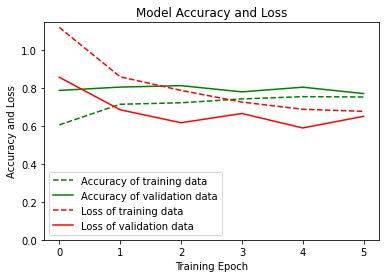


--- Check against test data ---

6584/6584 [==============================] - 0s 29us/step

Accuracy on test data: 0.81

Loss on test data: 0.51

--- Confusion matrix for test data ---



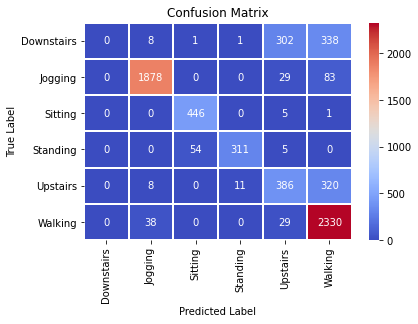


--- Classification report for test data ---

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       650
           1       0.97      0.94      0.96      1990
           2       0.89      0.99      0.94       452
           3       0.96      0.84      0.90       370
           4       0.51      0.53      0.52       725
           5       0.76      0.97      0.85      2397

    accuracy                           0.81      6584
   macro avg       0.68      0.71      0.69      6584
weighted avg       0.74      0.81      0.77      6584



/Users/narengs7/Anaconda/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [16]:
print("\n--- Create neural network model ---\n")

# 1D CNN neural network
model_m = Sequential()
model_m.add(Reshape((TIME_PERIODS, num_sensors), input_shape=(input_shape,)))
model_m.add(Conv1D(10, 5, activation='relu', input_shape=(TIME_PERIODS, num_sensors)))
model_m.add(MaxPooling1D(3))
model_m.add(Conv1D(10, 10, activation='relu'))
model_m.add(Conv1D(10, 10, activation='relu'))
model_m.add(GlobalAveragePooling1D())
model_m.add(Dropout(0.5))
model_m.add(Dense(num_classes, activation='softmax'))
print(model_m.summary())
# Accuracy on training data: 99%
# Accuracy on test data: 91%

print("\n--- Fit the model ---\n")

# The EarlyStopping callback monitors training accuracy:
# if it fails to improve for two consecutive epochs,
# training stops early
callbacks_list = [
    keras.callbacks.EarlyStopping(monitor='accuracy', patience=1)
]

model_m.compile(loss='categorical_crossentropy',
                optimizer='adam', metrics=['accuracy'])

BATCH_SIZE = 25
EPOCHS = 10

# Enable validation to use ModelCheckpoint and EarlyStopping callbacks.
history = model_m.fit(x_train,
                      y_train,
                      batch_size=BATCH_SIZE,
                      epochs=EPOCHS,
                      callbacks=callbacks_list,
                      validation_split=0.2,
                      verbose=1)

print("\n--- Learning curve of model training ---\n")

# summarize history for accuracy and loss
plt.figure(figsize=(6, 4))
plt.plot(history.history['accuracy'], "g--", label="Accuracy of training data")
plt.plot(history.history['val_accuracy'], "g", label="Accuracy of validation data")
plt.plot(history.history['loss'], "r--", label="Loss of training data")
plt.plot(history.history['val_loss'], "r", label="Loss of validation data")
plt.title('Model Accuracy and Loss')
plt.ylabel('Accuracy and Loss')
plt.xlabel('Training Epoch')
plt.ylim(0)
plt.legend()
plt.show()
print("\n--- Check against test data ---\n")

score = model_m.evaluate(x_test, y_test, verbose=1)

print("\nAccuracy on test data: %0.2f" % score[1])
print("\nLoss on test data: %0.2f" % score[0])

print("\n--- Confusion matrix for test data ---\n")

y_pred_test = model_m.predict(x_test)
# Take the class with the highest probability from the test predictions
max_y_pred_test = np.argmax(y_pred_test, axis=1)
max_y_test = np.argmax(y_test, axis=1)

show_confusion_matrix(max_y_test, max_y_pred_test)
print("\n--- Classification report for test data ---\n")

print(classification_report(max_y_test, max_y_pred_test))


--- Create neural network model ---

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_12 (Reshape)         (None, 80, 3)             0         
_________________________________________________________________
conv1d_26 (Conv1D)           (None, 71, 100)           3100      
_________________________________________________________________
conv1d_27 (Conv1D)           (None, 62, 180)           180180    
_________________________________________________________________
global_average_pooling1d_10  (None, 180)               0         
_________________________________________________________________
dense_12 (Dense)             (None, 6)                 1086      
Total params: 184,366
Trainable params: 184,366
Non-trainable params: 0
_________________________________________________________________
None

--- Fit the model ---

Train on 16694 samples, validate on 4174 sampl

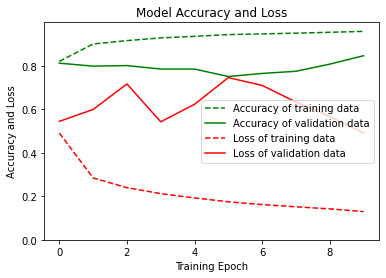


--- Check against test data ---

6584/6584 [==============================] - 1s 216us/step

Accuracy on test data: 0.91

Loss on test data: 0.31

--- Confusion matrix for test data ---



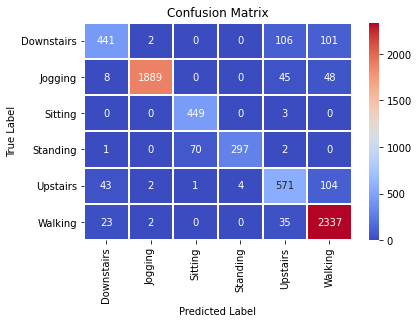


--- Classification report for test data ---

              precision    recall  f1-score   support

           0       0.85      0.68      0.76       650
           1       1.00      0.95      0.97      1990
           2       0.86      0.99      0.92       452
           3       0.99      0.80      0.89       370
           4       0.75      0.79      0.77       725
           5       0.90      0.97      0.94      2397

    accuracy                           0.91      6584
   macro avg       0.89      0.86      0.87      6584
weighted avg       0.91      0.91      0.91      6584



In [19]:
print("\n--- Create neural network model ---\n")

# 1D CNN neural network
model_m = Sequential()
model_m.add(Reshape((TIME_PERIODS, num_sensors), input_shape=(input_shape,)))
model_m.add(Conv1D(100, 10, activation='relu', input_shape=(TIME_PERIODS, num_sensors)))
# model_m.add(MaxPooling1D(3))
model_m.add(Conv1D(180, 10, activation='relu'))
model_m.add(GlobalAveragePooling1D())
# model_m.add(Dropout(0.5))
model_m.add(Dense(num_classes, activation='softmax'))
print(model_m.summary())
# Accuracy on training data: 99%
# Accuracy on test data: 91%

print("\n--- Fit the model ---\n")

# The EarlyStopping callback monitors training accuracy:
# if it fails to improve for two consecutive epochs,
# training stops early
callbacks_list = [
    keras.callbacks.EarlyStopping(monitor='accuracy', patience=1)
]

model_m.compile(loss='categorical_crossentropy',
                optimizer='adam', metrics=['accuracy'])

BATCH_SIZE = 25
EPOCHS = 10

# Enable validation to use ModelCheckpoint and EarlyStopping callbacks.
history = model_m.fit(x_train,
                      y_train,
                      batch_size=BATCH_SIZE,
                      epochs=EPOCHS,
                      callbacks=callbacks_list,
                      validation_split=0.2,
                      verbose=1)

print("\n--- Learning curve of model training ---\n")

# summarize history for accuracy and loss
plt.figure(figsize=(6, 4))
plt.plot(history.history['accuracy'], "g--", label="Accuracy of training data")
plt.plot(history.history['val_accuracy'], "g", label="Accuracy of validation data")
plt.plot(history.history['loss'], "r--", label="Loss of training data")
plt.plot(history.history['val_loss'], "r", label="Loss of validation data")
plt.title('Model Accuracy and Loss')
plt.ylabel('Accuracy and Loss')
plt.xlabel('Training Epoch')
plt.ylim(0)
plt.legend()
plt.show()
print("\n--- Check against test data ---\n")

score = model_m.evaluate(x_test, y_test, verbose=1)

print("\nAccuracy on test data: %0.2f" % score[1])
print("\nLoss on test data: %0.2f" % score[0])

print("\n--- Confusion matrix for test data ---\n")

y_pred_test = model_m.predict(x_test)
# Take the class with the highest probability from the test predictions
max_y_pred_test = np.argmax(y_pred_test, axis=1)
max_y_test = np.argmax(y_test, axis=1)

show_confusion_matrix(max_y_test, max_y_pred_test)
print("\n--- Classification report for test data ---\n")

print(classification_report(max_y_test, max_y_pred_test))


--- Create neural network model ---

Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_16 (Reshape)         (None, 80, 3)             0         
_________________________________________________________________
conv1d_31 (Conv1D)           (None, 71, 100)           3100      
_________________________________________________________________
global_average_pooling1d_14  (None, 100)               0         
_________________________________________________________________
dense_16 (Dense)             (None, 6)                 606       
Total params: 3,706
Trainable params: 3,706
Non-trainable params: 0
_________________________________________________________________
None

--- Fit the model ---

Train on 16694 samples, validate on 4174 samples
Epoch 1/100
16694/16694 [==============================] - 1s 63us/step - loss: 1.4290 - accuracy: 0.5484 - val_loss: 1.1616 - val_ac

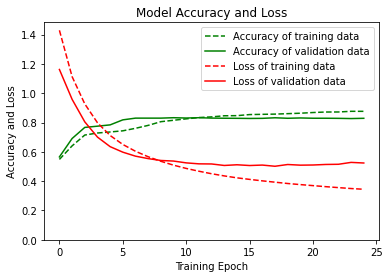


--- Check against test data ---

6584/6584 [==============================] - 0s 60us/step

Accuracy on test data: 0.85

Loss on test data: 0.51

--- Confusion matrix for test data ---



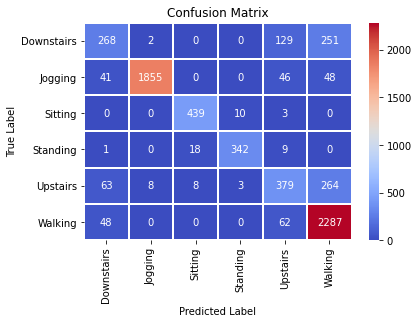


--- Classification report for test data ---

              precision    recall  f1-score   support

           0       0.64      0.41      0.50       650
           1       0.99      0.93      0.96      1990
           2       0.94      0.97      0.96       452
           3       0.96      0.92      0.94       370
           4       0.60      0.52      0.56       725
           5       0.80      0.95      0.87      2397

    accuracy                           0.85      6584
   macro avg       0.82      0.79      0.80      6584
weighted avg       0.84      0.85      0.84      6584



In [23]:
print("\n--- Create neural network model ---\n")

# 1D CNN neural network
model_m = Sequential()
model_m.add(Reshape((TIME_PERIODS, num_sensors), input_shape=(input_shape,)))
model_m.add(Conv1D(100, 10, activation='relu', input_shape=(TIME_PERIODS, num_sensors)))
# model_m.add(Conv1D(180, 10, activation='relu'))

model_m.add(GlobalAveragePooling1D())
model_m.add(Dense(num_classes, activation='softmax'))
print(model_m.summary())
# Accuracy on training data: 99%
# Accuracy on test data: 91%

print("\n--- Fit the model ---\n")

# The EarlyStopping callback monitors training accuracy:
# if it fails to improve for two consecutive epochs,
# training stops early
callbacks_list = [
    keras.callbacks.EarlyStopping(monitor='accuracy', patience=1)
]

model_m.compile(loss='categorical_crossentropy',
                optimizer='adam', metrics=['accuracy'])

BATCH_SIZE = 400
EPOCHS = 100

# Enable validation to use ModelCheckpoint and EarlyStopping callbacks.
history = model_m.fit(x_train,
                      y_train,
                      batch_size=BATCH_SIZE,
                      epochs=EPOCHS,
                      callbacks=callbacks_list,
                      validation_split=0.2,
                      verbose=1)

print("\n--- Learning curve of model training ---\n")

# summarize history for accuracy and loss
plt.figure(figsize=(6, 4))
plt.plot(history.history['accuracy'], "g--", label="Accuracy of training data")
plt.plot(history.history['val_accuracy'], "g", label="Accuracy of validation data")
plt.plot(history.history['loss'], "r--", label="Loss of training data")
plt.plot(history.history['val_loss'], "r", label="Loss of validation data")
plt.title('Model Accuracy and Loss')
plt.ylabel('Accuracy and Loss')
plt.xlabel('Training Epoch')
plt.ylim(0)
plt.legend()
plt.show()
print("\n--- Check against test data ---\n")

score = model_m.evaluate(x_test, y_test, verbose=1)

print("\nAccuracy on test data: %0.2f" % score[1])
print("\nLoss on test data: %0.2f" % score[0])

print("\n--- Confusion matrix for test data ---\n")

y_pred_test = model_m.predict(x_test)
# Take the class with the highest probability from the test predictions
max_y_pred_test = np.argmax(y_pred_test, axis=1)
max_y_test = np.argmax(y_test, axis=1)

show_confusion_matrix(max_y_test, max_y_pred_test)
print("\n--- Classification report for test data ---\n")

print(classification_report(max_y_test, max_y_pred_test))


--- Create neural network model ---

Model: "sequential_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_18 (Reshape)         (None, 80, 3)             0         
_________________________________________________________________
conv1d_33 (Conv1D)           (None, 71, 10)            310       
_________________________________________________________________
global_average_pooling1d_16  (None, 10)                0         
_________________________________________________________________
dense_18 (Dense)             (None, 6)                 66        
Total params: 376
Trainable params: 376
Non-trainable params: 0
_________________________________________________________________
None

--- Fit the model ---

Train on 16694 samples, validate on 4174 samples
Epoch 1/100
16694/16694 [==============================] - 0s 23us/step - loss: 1.6819 - accuracy: 0.2497 - val_loss: 1.5175 - val_accura

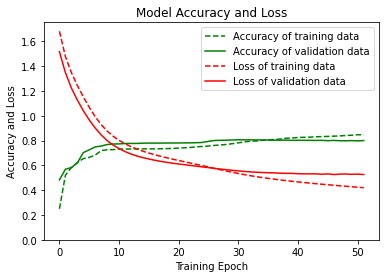


--- Check against test data ---

6584/6584 [==============================] - 0s 24us/step

Accuracy on test data: 0.82

Loss on test data: 0.56

--- Confusion matrix for test data ---



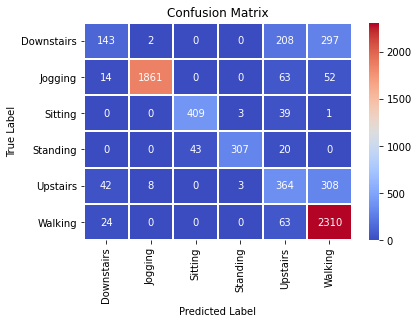


--- Classification report for test data ---

              precision    recall  f1-score   support

           0       0.64      0.22      0.33       650
           1       0.99      0.94      0.96      1990
           2       0.90      0.90      0.90       452
           3       0.98      0.83      0.90       370
           4       0.48      0.50      0.49       725
           5       0.78      0.96      0.86      2397

    accuracy                           0.82      6584
   macro avg       0.80      0.73      0.74      6584
weighted avg       0.82      0.82      0.80      6584



In [25]:
print("\n--- Create neural network model ---\n")

# 1D CNN neural network
model_m = Sequential()
model_m.add(Reshape((TIME_PERIODS, num_sensors), input_shape=(input_shape,)))
model_m.add(Conv1D(50, 10, activation='relu', input_shape=(TIME_PERIODS, num_sensors)))


model_m.add(GlobalAveragePooling1D())
model_m.add(Dense(num_classes, activation='softmax'))
print(model_m.summary())
# Accuracy on training data: 99%
# Accuracy on test data: 91%

print("\n--- Fit the model ---\n")

# The EarlyStopping callback monitors training accuracy:
# if it fails to improve for two consecutive epochs,
# training stops early
callbacks_list = [
    keras.callbacks.EarlyStopping(monitor='accuracy', patience=1)
]

model_m.compile(loss='categorical_crossentropy',
                optimizer='adam', metrics=['accuracy'])

BATCH_SIZE = 400
EPOCHS = 100

# Enable validation to use ModelCheckpoint and EarlyStopping callbacks.
history = model_m.fit(x_train,
                      y_train,
                      batch_size=BATCH_SIZE,
                      epochs=EPOCHS,
                      callbacks=callbacks_list,
                      validation_split=0.2,
                      verbose=1)

print("\n--- Learning curve of model training ---\n")

# summarize history for accuracy and loss
plt.figure(figsize=(6, 4))
plt.plot(history.history['accuracy'], "g--", label="Accuracy of training data")
plt.plot(history.history['val_accuracy'], "g", label="Accuracy of validation data")
plt.plot(history.history['loss'], "r--", label="Loss of training data")
plt.plot(history.history['val_loss'], "r", label="Loss of validation data")
plt.title('Model Accuracy and Loss')
plt.ylabel('Accuracy and Loss')
plt.xlabel('Training Epoch')
plt.ylim(0)
plt.legend()
plt.show()
print("\n--- Check against test data ---\n")

score = model_m.evaluate(x_test, y_test, verbose=1)

print("\nAccuracy on test data: %0.2f" % score[1])
print("\nLoss on test data: %0.2f" % score[0])

print("\n--- Confusion matrix for test data ---\n")

y_pred_test = model_m.predict(x_test)
# Take the class with the highest probability from the test predictions
max_y_pred_test = np.argmax(y_pred_test, axis=1)
max_y_test = np.argmax(y_test, axis=1)

show_confusion_matrix(max_y_test, max_y_pred_test)
print("\n--- Classification report for test data ---\n")

print(classification_report(max_y_test, max_y_pred_test))


--- Create neural network model ---

Model: "sequential_22"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_22 (Reshape)         (None, 80, 3)             0         
_________________________________________________________________
conv1d_37 (Conv1D)           (None, 71, 10)            310       
_________________________________________________________________
global_average_pooling1d_20  (None, 10)                0         
_________________________________________________________________
dense_22 (Dense)             (None, 6)                 66        
Total params: 376
Trainable params: 376
Non-trainable params: 0
_________________________________________________________________
None

--- Fit the model ---

Train on 16694 samples, validate on 4174 samples
Epoch 1/100
16694/16694 [==============================] - 0s 29us/step - loss: 1.7703 - accuracy: 0.2539 - val_loss: 1.6535 - val_accura

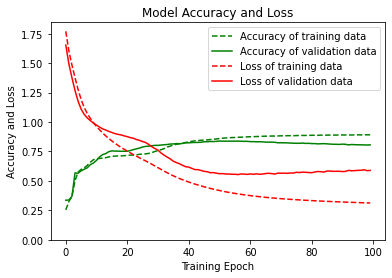


--- Check against test data ---

6584/6584 [==============================] - 0s 24us/step

Accuracy on test data: 0.85

Loss on test data: 0.51

--- Confusion matrix for test data ---



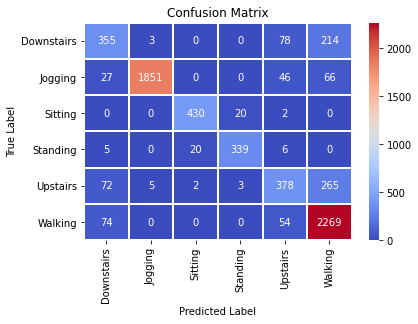


--- Classification report for test data ---

              precision    recall  f1-score   support

           0       0.67      0.55      0.60       650
           1       1.00      0.93      0.96      1990
           2       0.95      0.95      0.95       452
           3       0.94      0.92      0.93       370
           4       0.67      0.52      0.59       725
           5       0.81      0.95      0.87      2397

    accuracy                           0.85      6584
   macro avg       0.84      0.80      0.82      6584
weighted avg       0.85      0.85      0.85      6584



In [29]:
print("\n--- Create neural network model ---\n")

# 1D CNN neural network
model_m = Sequential()
model_m.add(Reshape((TIME_PERIODS, num_sensors), input_shape=(input_shape,)))
model_m.add(Conv1D(10, 10, activation='relu', input_shape=(TIME_PERIODS, num_sensors)))
# model_m.add(Conv1D(180, 10, activation='relu'))

model_m.add(GlobalAveragePooling1D())
model_m.add(Dense(num_classes, activation='softmax'))
print(model_m.summary())

print("\n--- Fit the model ---\n")

# The EarlyStopping callback monitors training accuracy:
# if it fails to improve for two consecutive epochs,
# training stops early
# callbacks_list = [
#     keras.callbacks.EarlyStopping(monitor='accuracy', patience=1)
# ]

model_m.compile(loss='categorical_crossentropy',
                optimizer='adam', metrics=['accuracy'])

BATCH_SIZE = 400
EPOCHS = 100

# Enable validation to use ModelCheckpoint and EarlyStopping callbacks.
history = model_m.fit(x_train,
                      y_train,
                      batch_size=BATCH_SIZE,
                      epochs=EPOCHS,
                      validation_split=0.2,
                      verbose=1)

print("\n--- Learning curve of model training ---\n")

# summarize history for accuracy and loss
plt.figure(figsize=(6, 4))
plt.plot(history.history['accuracy'], "g--", label="Accuracy of training data")
plt.plot(history.history['val_accuracy'], "g", label="Accuracy of validation data")
plt.plot(history.history['loss'], "r--", label="Loss of training data")
plt.plot(history.history['val_loss'], "r", label="Loss of validation data")
plt.title('Model Accuracy and Loss')
plt.ylabel('Accuracy and Loss')
plt.xlabel('Training Epoch')
plt.ylim(0)
plt.legend()
plt.show()
print("\n--- Check against test data ---\n")

score = model_m.evaluate(x_test, y_test, verbose=1)

print("\nAccuracy on test data: %0.2f" % score[1])
print("\nLoss on test data: %0.2f" % score[0])

print("\n--- Confusion matrix for test data ---\n")

y_pred_test = model_m.predict(x_test)
# Take the class with the highest probability from the test predictions
max_y_pred_test = np.argmax(y_pred_test, axis=1)
max_y_test = np.argmax(y_test, axis=1)

show_confusion_matrix(max_y_test, max_y_pred_test)
print("\n--- Classification report for test data ---\n")

print(classification_report(max_y_test, max_y_pred_test))


--- Create neural network model ---

Model: "sequential_23"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_23 (Reshape)         (None, 80, 3)             0         
_________________________________________________________________
conv1d_38 (Conv1D)           (None, 71, 10)            310       
_________________________________________________________________
conv1d_39 (Conv1D)           (None, 62, 10)            1010      
_________________________________________________________________
global_average_pooling1d_21  (None, 10)                0         
_________________________________________________________________
dense_23 (Dense)             (None, 6)                 66        
Total params: 1,386
Trainable params: 1,386
Non-trainable params: 0
_________________________________________________________________
None

--- Fit the model ---

Train on 16694 samples, validate on 4174 samples
E

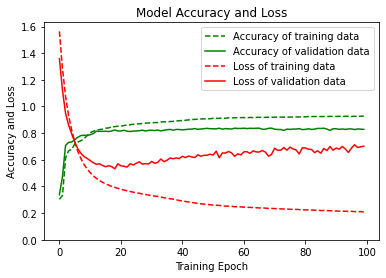


--- Check against test data ---

6584/6584 [==============================] - 0s 30us/step

Accuracy on test data: 0.88

Loss on test data: 0.40

--- Confusion matrix for test data ---



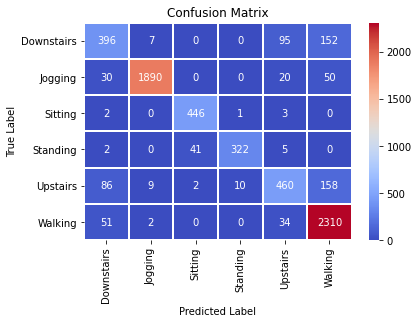


--- Classification report for test data ---

              precision    recall  f1-score   support

           0       0.70      0.61      0.65       650
           1       0.99      0.95      0.97      1990
           2       0.91      0.99      0.95       452
           3       0.97      0.87      0.92       370
           4       0.75      0.63      0.69       725
           5       0.87      0.96      0.91      2397

    accuracy                           0.88      6584
   macro avg       0.86      0.84      0.85      6584
weighted avg       0.88      0.88      0.88      6584



In [30]:
print("\n--- Create neural network model ---\n")

# 1D CNN neural network
model_m = Sequential()
model_m.add(Reshape((TIME_PERIODS, num_sensors), input_shape=(input_shape,)))
model_m.add(Conv1D(10, 10, activation='relu', input_shape=(TIME_PERIODS, num_sensors)))
model_m.add(Conv1D(10, 10, activation='relu', input_shape=(TIME_PERIODS, num_sensors)))
# model_m.add(Conv1D(180, 10, activation='relu'))

model_m.add(GlobalAveragePooling1D())
model_m.add(Dense(num_classes, activation='softmax'))
print(model_m.summary())

print("\n--- Fit the model ---\n")

# The EarlyStopping callback monitors training accuracy:
# if it fails to improve for two consecutive epochs,
# training stops early
# callbacks_list = [
#     keras.callbacks.EarlyStopping(monitor='accuracy', patience=1)
# ]

model_m.compile(loss='categorical_crossentropy',
                optimizer='adam', metrics=['accuracy'])

BATCH_SIZE = 400
EPOCHS = 100

# Enable validation to use ModelCheckpoint and EarlyStopping callbacks.
history = model_m.fit(x_train,
                      y_train,
                      batch_size=BATCH_SIZE,
                      epochs=EPOCHS,
                      validation_split=0.2,
                      verbose=1)

print("\n--- Learning curve of model training ---\n")

# summarize history for accuracy and loss
plt.figure(figsize=(6, 4))
plt.plot(history.history['accuracy'], "g--", label="Accuracy of training data")
plt.plot(history.history['val_accuracy'], "g", label="Accuracy of validation data")
plt.plot(history.history['loss'], "r--", label="Loss of training data")
plt.plot(history.history['val_loss'], "r", label="Loss of validation data")
plt.title('Model Accuracy and Loss')
plt.ylabel('Accuracy and Loss')
plt.xlabel('Training Epoch')
plt.ylim(0)
plt.legend()
plt.show()
print("\n--- Check against test data ---\n")

score = model_m.evaluate(x_test, y_test, verbose=1)

print("\nAccuracy on test data: %0.2f" % score[1])
print("\nLoss on test data: %0.2f" % score[0])

print("\n--- Confusion matrix for test data ---\n")

y_pred_test = model_m.predict(x_test)
# Take the class with the highest probability from the test predictions
max_y_pred_test = np.argmax(y_pred_test, axis=1)
max_y_test = np.argmax(y_test, axis=1)

show_confusion_matrix(max_y_test, max_y_pred_test)
print("\n--- Classification report for test data ---\n")

print(classification_report(max_y_test, max_y_pred_test))


--- Create neural network model ---

Model: "sequential_24"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_24 (Reshape)         (None, 80, 3)             0         
_________________________________________________________________
conv1d_40 (Conv1D)           (None, 71, 10)            310       
_________________________________________________________________
conv1d_41 (Conv1D)           (None, 62, 10)            1010      
_________________________________________________________________
conv1d_42 (Conv1D)           (None, 53, 10)            1010      
_________________________________________________________________
global_average_pooling1d_22  (None, 10)                0         
_________________________________________________________________
dense_24 (Dense)             (None, 6)                 66        
Total params: 2,396
Trainable params: 2,396
Non-trainable params: 0
_____________

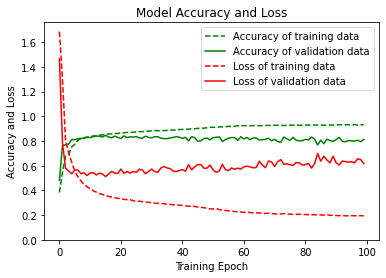


--- Check against test data ---

6584/6584 [==============================] - 0s 40us/step

Accuracy on test data: 0.89

Loss on test data: 0.40

--- Confusion matrix for test data ---



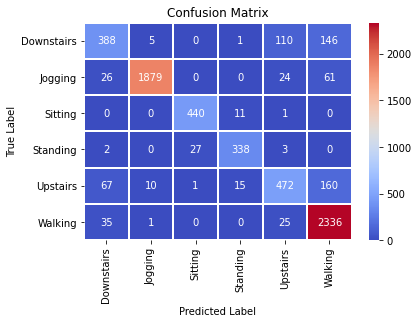


--- Classification report for test data ---

              precision    recall  f1-score   support

           0       0.75      0.60      0.66       650
           1       0.99      0.94      0.97      1990
           2       0.94      0.97      0.96       452
           3       0.93      0.91      0.92       370
           4       0.74      0.65      0.69       725
           5       0.86      0.97      0.92      2397

    accuracy                           0.89      6584
   macro avg       0.87      0.84      0.85      6584
weighted avg       0.89      0.89      0.89      6584



In [31]:
print("\n--- Create neural network model ---\n")

# 1D CNN neural network
model_m = Sequential()
model_m.add(Reshape((TIME_PERIODS, num_sensors), input_shape=(input_shape,)))
model_m.add(Conv1D(10, 10, activation='relu', input_shape=(TIME_PERIODS, num_sensors)))
model_m.add(Conv1D(10, 10, activation='relu', input_shape=(TIME_PERIODS, num_sensors)))
model_m.add(Conv1D(10, 10, activation='relu', input_shape=(TIME_PERIODS, num_sensors)))
# model_m.add(Conv1D(180, 10, activation='relu'))

model_m.add(GlobalAveragePooling1D())
model_m.add(Dense(num_classes, activation='softmax'))
print(model_m.summary())

print("\n--- Fit the model ---\n")

# The EarlyStopping callback monitors training accuracy:
# if it fails to improve for two consecutive epochs,
# training stops early
# callbacks_list = [
#     keras.callbacks.EarlyStopping(monitor='accuracy', patience=1)
# ]

model_m.compile(loss='categorical_crossentropy',
                optimizer='adam', metrics=['accuracy'])

BATCH_SIZE = 400
EPOCHS = 100

# Enable validation to use ModelCheckpoint and EarlyStopping callbacks.
history = model_m.fit(x_train,
                      y_train,
                      batch_size=BATCH_SIZE,
                      epochs=EPOCHS,
                      validation_split=0.2,
                      verbose=1)

print("\n--- Learning curve of model training ---\n")

# summarize history for accuracy and loss
plt.figure(figsize=(6, 4))
plt.plot(history.history['accuracy'], "g--", label="Accuracy of training data")
plt.plot(history.history['val_accuracy'], "g", label="Accuracy of validation data")
plt.plot(history.history['loss'], "r--", label="Loss of training data")
plt.plot(history.history['val_loss'], "r", label="Loss of validation data")
plt.title('Model Accuracy and Loss')
plt.ylabel('Accuracy and Loss')
plt.xlabel('Training Epoch')
plt.ylim(0)
plt.legend()
plt.show()
print("\n--- Check against test data ---\n")

score = model_m.evaluate(x_test, y_test, verbose=1)

print("\nAccuracy on test data: %0.2f" % score[1])
print("\nLoss on test data: %0.2f" % score[0])

print("\n--- Confusion matrix for test data ---\n")

y_pred_test = model_m.predict(x_test)
# Take the class with the highest probability from the test predictions
max_y_pred_test = np.argmax(y_pred_test, axis=1)
max_y_test = np.argmax(y_test, axis=1)

show_confusion_matrix(max_y_test, max_y_pred_test)
print("\n--- Classification report for test data ---\n")

print(classification_report(max_y_test, max_y_pred_test))


--- Create neural network model ---

Model: "sequential_25"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_25 (Reshape)         (None, 80, 3)             0         
_________________________________________________________________
conv1d_43 (Conv1D)           (None, 71, 10)            310       
_________________________________________________________________
conv1d_44 (Conv1D)           (None, 62, 10)            1010      
_________________________________________________________________
conv1d_45 (Conv1D)           (None, 53, 10)            1010      
_________________________________________________________________
conv1d_46 (Conv1D)           (None, 44, 10)            1010      
_________________________________________________________________
global_average_pooling1d_23  (None, 10)                0         
_________________________________________________________________
dense_25 (Dense

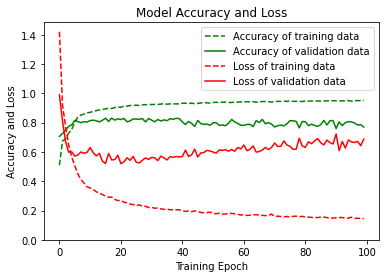


--- Check against test data ---

6584/6584 [==============================] - 0s 49us/step

Accuracy on test data: 0.90

Loss on test data: 0.37

--- Confusion matrix for test data ---



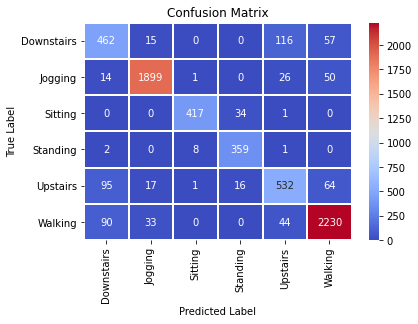


--- Classification report for test data ---

              precision    recall  f1-score   support

           0       0.70      0.71      0.70       650
           1       0.97      0.95      0.96      1990
           2       0.98      0.92      0.95       452
           3       0.88      0.97      0.92       370
           4       0.74      0.73      0.74       725
           5       0.93      0.93      0.93      2397

    accuracy                           0.90      6584
   macro avg       0.86      0.87      0.87      6584
weighted avg       0.90      0.90      0.90      6584



In [32]:
print("\n--- Create neural network model ---\n")

# 1D CNN neural network
model_m = Sequential()
model_m.add(Reshape((TIME_PERIODS, num_sensors), input_shape=(input_shape,)))
model_m.add(Conv1D(10, 10, activation='relu', input_shape=(TIME_PERIODS, num_sensors)))
model_m.add(Conv1D(10, 10, activation='relu', input_shape=(TIME_PERIODS, num_sensors)))
model_m.add(Conv1D(10, 10, activation='relu', input_shape=(TIME_PERIODS, num_sensors)))
model_m.add(Conv1D(10, 10, activation='relu', input_shape=(TIME_PERIODS, num_sensors)))
# model_m.add(Conv1D(180, 10, activation='relu'))

model_m.add(GlobalAveragePooling1D())
model_m.add(Dense(num_classes, activation='softmax'))
print(model_m.summary())

print("\n--- Fit the model ---\n")

# The EarlyStopping callback monitors training accuracy:
# if it fails to improve for two consecutive epochs,
# training stops early
# callbacks_list = [
#     keras.callbacks.EarlyStopping(monitor='accuracy', patience=1)
# ]

model_m.compile(loss='categorical_crossentropy',
                optimizer='adam', metrics=['accuracy'])

BATCH_SIZE = 400
EPOCHS = 100

# Enable validation to use ModelCheckpoint and EarlyStopping callbacks.
history = model_m.fit(x_train,
                      y_train,
                      batch_size=BATCH_SIZE,
                      epochs=EPOCHS,
                      validation_split=0.2,
                      verbose=1)

print("\n--- Learning curve of model training ---\n")

# summarize history for accuracy and loss
plt.figure(figsize=(6, 4))
plt.plot(history.history['accuracy'], "g--", label="Accuracy of training data")
plt.plot(history.history['val_accuracy'], "g", label="Accuracy of validation data")
plt.plot(history.history['loss'], "r--", label="Loss of training data")
plt.plot(history.history['val_loss'], "r", label="Loss of validation data")
plt.title('Model Accuracy and Loss')
plt.ylabel('Accuracy and Loss')
plt.xlabel('Training Epoch')
plt.ylim(0)
plt.legend()
plt.show()
print("\n--- Check against test data ---\n")

score = model_m.evaluate(x_test, y_test, verbose=1)

print("\nAccuracy on test data: %0.2f" % score[1])
print("\nLoss on test data: %0.2f" % score[0])

print("\n--- Confusion matrix for test data ---\n")

y_pred_test = model_m.predict(x_test)
# Take the class with the highest probability from the test predictions
max_y_pred_test = np.argmax(y_pred_test, axis=1)
max_y_test = np.argmax(y_test, axis=1)

show_confusion_matrix(max_y_test, max_y_pred_test)
print("\n--- Classification report for test data ---\n")

print(classification_report(max_y_test, max_y_pred_test))


--- Create neural network model ---

Model: "sequential_26"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_26 (Reshape)         (None, 80, 3)             0         
_________________________________________________________________
conv1d_47 (Conv1D)           (None, 71, 10)            310       
_________________________________________________________________
conv1d_48 (Conv1D)           (None, 62, 10)            1010      
_________________________________________________________________
conv1d_49 (Conv1D)           (None, 53, 10)            1010      
_________________________________________________________________
conv1d_50 (Conv1D)           (None, 44, 10)            1010      
_________________________________________________________________
conv1d_51 (Conv1D)           (None, 35, 10)            1010      
_________________________________________________________________
global_average_

16694/16694 [==============================] - 1s 79us/step - loss: 0.1154 - accuracy: 0.9635 - val_loss: 0.6892 - val_accuracy: 0.8052

--- Learning curve of model training ---



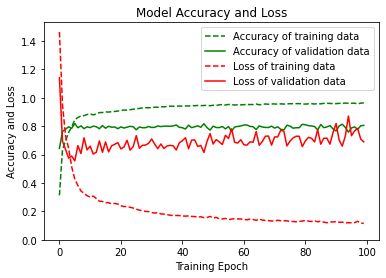


--- Check against test data ---

6584/6584 [==============================] - 0s 45us/step

Accuracy on test data: 0.87

Loss on test data: 0.57

--- Confusion matrix for test data ---



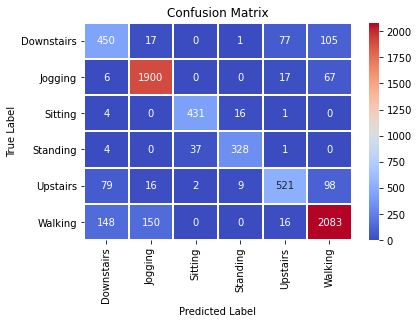


--- Classification report for test data ---

              precision    recall  f1-score   support

           0       0.65      0.69      0.67       650
           1       0.91      0.95      0.93      1990
           2       0.92      0.95      0.93       452
           3       0.93      0.89      0.91       370
           4       0.82      0.72      0.77       725
           5       0.89      0.87      0.88      2397

    accuracy                           0.87      6584
   macro avg       0.85      0.85      0.85      6584
weighted avg       0.87      0.87      0.87      6584



In [33]:
print("\n--- Create neural network model ---\n")

# 1D CNN neural network
model_m = Sequential()
model_m.add(Reshape((TIME_PERIODS, num_sensors), input_shape=(input_shape,)))
model_m.add(Conv1D(10, 10, activation='relu', input_shape=(TIME_PERIODS, num_sensors)))
model_m.add(Conv1D(10, 10, activation='relu', input_shape=(TIME_PERIODS, num_sensors)))
model_m.add(Conv1D(10, 10, activation='relu', input_shape=(TIME_PERIODS, num_sensors)))
model_m.add(Conv1D(10, 10, activation='relu', input_shape=(TIME_PERIODS, num_sensors)))
model_m.add(Conv1D(10, 10, activation='relu', input_shape=(TIME_PERIODS, num_sensors)))
# model_m.add(Conv1D(180, 10, activation='relu'))

model_m.add(GlobalAveragePooling1D())
model_m.add(Dense(num_classes, activation='softmax'))
print(model_m.summary())

print("\n--- Fit the model ---\n")

# The EarlyStopping callback monitors training accuracy:
# if it fails to improve for two consecutive epochs,
# training stops early
# callbacks_list = [
#     keras.callbacks.EarlyStopping(monitor='accuracy', patience=1)
# ]

model_m.compile(loss='categorical_crossentropy',
                optimizer='adam', metrics=['accuracy'])

BATCH_SIZE = 400
EPOCHS = 100

# Enable validation to use ModelCheckpoint and EarlyStopping callbacks.
history = model_m.fit(x_train,
                      y_train,
                      batch_size=BATCH_SIZE,
                      epochs=EPOCHS,
                      validation_split=0.2,
                      verbose=1)

print("\n--- Learning curve of model training ---\n")

# summarize history for accuracy and loss
plt.figure(figsize=(6, 4))
plt.plot(history.history['accuracy'], "g--", label="Accuracy of training data")
plt.plot(history.history['val_accuracy'], "g", label="Accuracy of validation data")
plt.plot(history.history['loss'], "r--", label="Loss of training data")
plt.plot(history.history['val_loss'], "r", label="Loss of validation data")
plt.title('Model Accuracy and Loss')
plt.ylabel('Accuracy and Loss')
plt.xlabel('Training Epoch')
plt.ylim(0)
plt.legend()
plt.show()
print("\n--- Check against test data ---\n")

score = model_m.evaluate(x_test, y_test, verbose=1)

print("\nAccuracy on test data: %0.2f" % score[1])
print("\nLoss on test data: %0.2f" % score[0])

print("\n--- Confusion matrix for test data ---\n")

y_pred_test = model_m.predict(x_test)
# Take the class with the highest probability from the test predictions
max_y_pred_test = np.argmax(y_pred_test, axis=1)
max_y_test = np.argmax(y_test, axis=1)

show_confusion_matrix(max_y_test, max_y_pred_test)
print("\n--- Classification report for test data ---\n")

print(classification_report(max_y_test, max_y_pred_test))